# Lab 4 (Due @ by 11:59 pm via Canvas/Gradescope)

#! snip: Lab4
# $\color{red}{\text{SOLUTIONS}}$ 
#! snip-end

Due: Tuesday Nov 28 @ 11:59 PM EST

### Submission Instructions
Submit this `ipynb` file to Gradescope (this can also be done via the assignment on Canvas).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh `Kernel > Restart & Run All` just before uploading the `ipynb` file to gradescope.

### Group Work

You are encouraged to work in groups for this Lab, however each student should submit their own notebook file to Gradescope. While each Part of the Lab depends on previous parts, talking through the problem with your group should help speed up both understanding and arriving at a solution. 

In [1]:
#! snip: Lab4

!python3 -m snip_copy Lab4_Solutions.ipynb

#! snip-end

snip-copied: Lab4.ipynb


In [2]:
# you might use the below modules on this lab
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pylab as py
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

## Part 1: Two Candidate Models (36 points)

For this lab, you will use [this data set from kaggle](https://www.kaggle.com/datasets/hijest/covid19-public-health-social-measures/data) which has been cleaned and is available in the Labs Module on Canvas. It contains data concerning COVID-19 Public Health Social Measures (PHSM) and a Global Severity Index which measures how severe COVID-19 cases were in a given country from the end of 2019 to August 2021. The features of interest are (with the corresponding notation for this problem):

- $y$: `GLOBAL_INDEX`, the severity index for the country at a specific date (range 1-88, lower values indicate less severe cases)
- $x_1$: `MASKS`, the enforcement of mask wearing as a measure (range 0-100, larger values indicate more enforcement)
- $x_2$: `TRAVEL`, the enforcement of travel restrictions as a measure (range 0-100)
- $x_3$: `GATHERINGS`, the enforcement of limiting large gatherings as a measure (range 0-50)
- $x_4$: `SCHOOLS`, the enforcement of school closures as a measure (range 0-100)
- $x_5$: `BUSINESSES`, the enforcement of business closures as a measure (range 0-133)
- $x_6$: `MOVEMENTS`, the enforcement of mask wearing as a measure (range 0-100)

Assume (for convenience) that all the features are already on the same scale. You have been discussing building a model to predict the `GLOBAL_INDEX` with the other numeric features with a couple experts. Here are what they say:

- **Expert 1:** "Keep in mind that what you'll see is that the features tend to have a positive impact on the index, which is to be expected (more enforcement generally correlates with more severe cases). Based on my own studies, I believe that all the features **except** `GATHERINGS` and `SCHOOLS` should be useful for predicting, and effect the `GLOBAL_INDEX` **linearly**, except that I believe `MASKS` should have a **cubic** effect; countries with no or low mask mandates should actually be more severe than those with some, though masking and severity should then rise together for awhile before leveling off."
- **Expert 2:** "I agree mostly with Expert 1, except I believe that `SCHOOLS` **should be** and `TRAVEL` **should not be** included, and I actually expect that `BUSINESSES` should be **quadratically** related to `GLOBAL_INDEX`; while severity and business closures should initially rise together, I expect there to be a leveling off towards the higher levels."

Based on these two experts' opinions, you will build the two candidate models. To start investigating them, perform the following tasks:

1. Read in the data set `phsm-severity-data.csv` into this notebook file using `pandas`, call it `df_covid`.
2. In a markdown cell, write out each of the models suggested by the experts in mathematical notation (i.e., a model including `MASKS` (cubicly) and `TRAVEL` would be: $\hat{y} = b_0 + b_1x_1 + b_2x_1^2 + b_3x_1^3 + b_4x_2$)
3. Create three scatter plots to investigate the relationships between (a) `TRAVEL` and `GLOBAL_INDEX`, (b) `SCHOOLS` and `GLOBAL_INDEX`, and (c) between `BUSINESSES` and `GLOBAL_INDEX`.
4. In a markdown cell, discuss whether these plots give you any intuition as to which model suggested by the experts may be more appropriate.

In [3]:
#! snip: Lab4

df_covid = pd.read_csv("phsm-severity-data.csv")
df_covid.head()

#! snip-end

,COUNTRY,WHO_REGION,MASKS,TRAVEL,GATHERINGS,SCHOOLS,BUSINESSES,MOVEMENTS,GLOBAL_INDEX
0,Yemen,EMRO,0,100,30,25,13,80,41
1,Belarus,EURO,67,0,25,25,13,40,28
2,Egypt,EMRO,100,33,50,25,67,100,62
3,Uzbekistan,EURO,100,100,25,75,67,40,68
4,Finland,EURO,47,100,5,25,67,20,44


#! snip: Lab4

Model A: $\hat{y} = b_0 + b_1x_1 + b_2x_1^2 + b_3x_1^3 + b_4x_2 + b_5x_5 + b_6x_6$
Model B: $\hat{y} = b_0 + b_1x_1 + b_2x_1^2 + b_3x_1^3 + b_4x_4 + b_5x_5 + b_6x_5^2 + b_7x_6$

#! snip-end

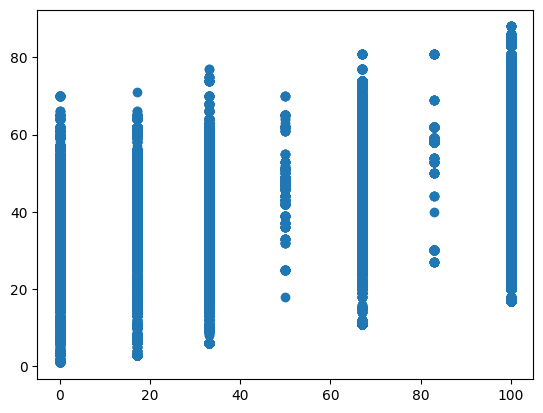

In [4]:
#! snip: Lab4

x3 = df_covid.TRAVEL.to_numpy()
y = df_covid.GLOBAL_INDEX.to_numpy()

plt.scatter(x3, y)

#! snip-end

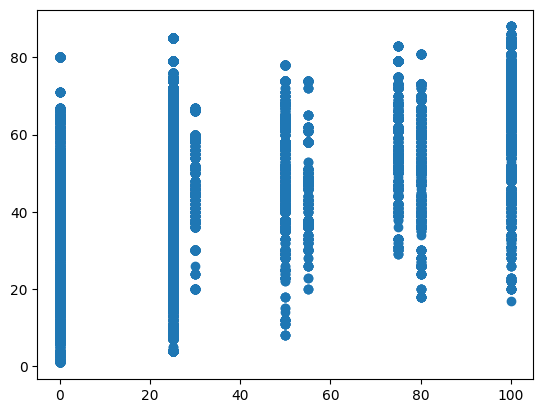

In [5]:
#! snip: Lab4

x4 = df_covid.SCHOOLS.to_numpy()

plt.scatter(x4, y)

#! snip-end

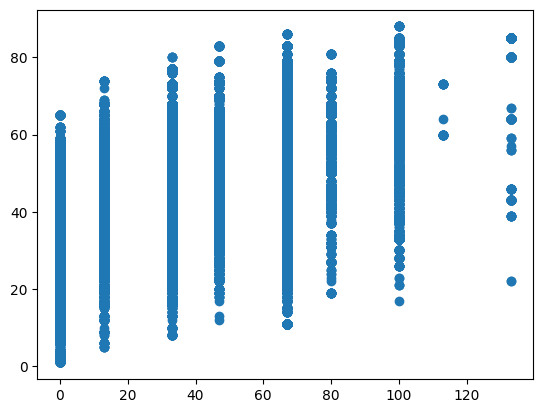

In [6]:
#! snip: Lab4

x5 = df_covid.BUSINESSES.to_numpy()

plt.scatter(x5, y)

#! snip-end

#! snip: Lab4

Based on the plots, I think probably *both* `TRAVEL` and `SCHOOLS` should be included, so I'm not sure I agree with the two experts that only one of them should be included (whichever one). However, based on the third plot (with `BUSINESSES`) I think Expert 2 may be on to something with the quadratic relationship, as it does seem to follow the pattern they suggested.

#! snip-end

# Part 2: Cross Validating to Fit and Compare (24 points)

To make this go faster, I have implemented 10-fold cross validation (there are over 100000 observations, so LOO-CV takes too long) to fit each of the candidate models and print out their cross validated $R^2$ values. I have also written the code to produce the relevant residual plots for checking the assumptions. You do not have to write any actual code, however, **you must read through the code** and write **DETAILED** comments on each code chunk where it says `# EXPLAIN THIS CHUNK:`.

## MODEL A (no `GATHERINGS` or `SCHOOLS`, with `TRAVEL`, `BUSINESSES` linear)

In [7]:
# EXPLAIN THIS CHUNK: 
poly_t = PolynomialFeatures(3)
x1_poly = poly_t.fit_transform(df_covid.MASKS.to_numpy().reshape(-1,1))
XA = np.column_stack([x1_poly,
                      df_covid.TRAVEL,
                      df_covid.BUSINESSES,
                      df_covid.MOVEMENTS])
y = df_covid.GLOBAL_INDEX.to_numpy()

y_predsA = np.empty_like(y)

# EXPLAIN THIS CHUNK:
kfoldA = KFold(n_splits=10)
for train_idx, test_idx in kfoldA.split(XA, y):
    XA_test = XA[test_idx, :]
    XA_train = XA[train_idx, :]
    y_train = y[train_idx]
     
    b_train = np.matmul(np.linalg.inv(np.matmul(XA_train.T, XA_train)), np.matmul(XA_train.T, y_train))
     
    y_predsA[test_idx] = np.matmul(XA_test, b_train)

# EXPLAIN THIS CHUNK:
eA = y - y_predsA
mseA = np.mean(eA ** 2)
r2A = 1 - (mseA/np.var(y))
print(r2A)

0.9162747280465839


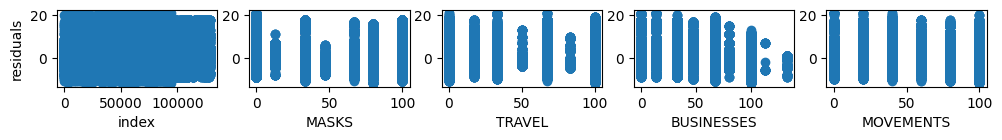

In [8]:
x_labels = ['index', 'MASKS', 'TRAVEL', 'BUSINESSES', 'MOVEMENTS']

# EXPLAIN THIS CHUNK: 
for plot in x_labels:
    plot_idx = x_labels.index(plot)
    plt.subplot(1, 5, plot_idx+1)
    if plot_idx == 0:
        plt.scatter(x = range(len(y)), y = eA)
        plt.xlabel(plot)
        plt.ylabel('residuals')
    else:
        plt.scatter(x = df_covid.loc[:,plot], y = eA)
        plt.xlabel(plot)
    
plt.gcf().set_size_inches(12, 1)

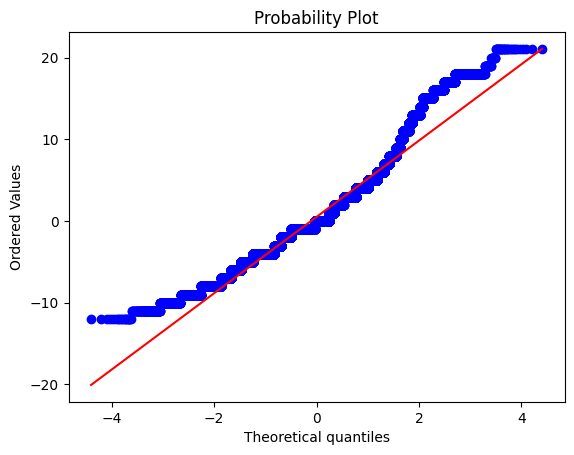

In [9]:
stats.probplot(eA, dist="norm", plot=py)
py.show()

## MODEL B (no `GATHERINGS` or `TRAVEL`, with `SCHOOLS`, `BUSINESSES` quadratic)

In [10]:
# EXPLAIN THIS CHUNK: 
poly_t2 = PolynomialFeatures(2)
x5_poly = poly_t2.fit_transform(df_covid.BUSINESSES.to_numpy().reshape(-1,1))
XB = np.column_stack([x1_poly,
                      df_covid.SCHOOLS,
                      x5_poly[:,1:],
                      df_covid.MOVEMENTS])

y_predsB = np.empty_like(y)

# EXPLAIN THIS CHUNK:
kfoldB = KFold(n_splits=10)
for train_idx, test_idx in kfoldB.split(XB, y):
    XB_test = XB[test_idx, :]
    XB_train = XB[train_idx, :]
    y_train = y[train_idx]
     
    b_train = np.matmul(np.linalg.inv(np.matmul(XB_train.T, XB_train)), np.matmul(XB_train.T, y_train))
     
    y_predsB[test_idx] = np.matmul(XB_test, b_train)

# EXPLAIN THIS CHUNK:
eB = y - y_predsB
mseB = np.mean(eB ** 2)
r2B = 1 - (mseB/np.var(y))
print(r2B)

0.8282630768506498


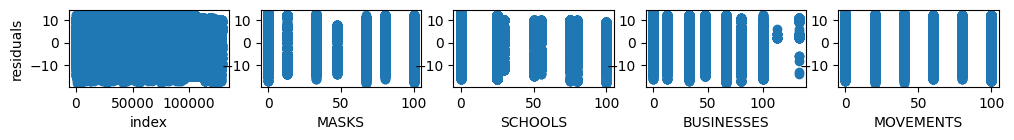

In [11]:
x_labels = ['index', 'MASKS', 'SCHOOLS', 'BUSINESSES', 'MOVEMENTS']

# EXPLAIN THIS CHUNK: 
for plot in x_labels:
    plot_idx = x_labels.index(plot)
    plt.subplot(1, 5, plot_idx+1)
    if plot_idx == 0:
        plt.scatter(x = range(len(y)), y = eB)
        plt.xlabel(plot)
        plt.ylabel('residuals')
    else:
        plt.scatter(x = df_covid.loc[:,plot], y = eB)
        plt.xlabel(plot)
    
plt.gcf().set_size_inches(12, 1)

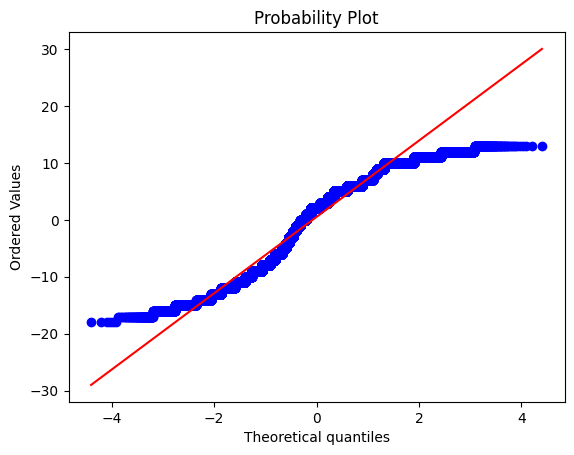

In [12]:
stats.probplot(eB, dist="norm", plot=py)
py.show()

# Part 3: Summarize and Outline Future Steps (40 points)

The code below fits the models (both model A and B) to the full data set and prints out the coefficients. Use these, as well as the results from Part 2 to write a **detailed** paragraph or two of **at least five sentences** which discusses:

- Do the slopes that the models have in common (for `MASKS` and `MOVEMENTS`) look similar or different? How would you interpret the coefficients that differentiate (for `TRAVEL`, `SCHOOLS`, and `BUSINESSES`) the models?
- How would you interpret the difference in the cross validated $R^2$ values of the two models?
- What would you say about how the assumptions were met, or not met, for the two models?
- Which expert would you say has the better idea of how the social measures predict severity index and why? (i.e., if you were forced to choose between the two models, which one would you choose and why?)
- What sort of improvements do you think you could make to either/both of the models to improve your ability to predict the severity index of COVID-19 in a country?

In [13]:
modelA = np.matmul(np.linalg.inv(np.matmul(XA.T, XA)), np.matmul(XA.T, y))
print(modelA.round(2))
modelB = np.matmul(np.linalg.inv(np.matmul(XB.T, XB)), np.matmul(XB.T, y))
print(modelB.round(2))

[ 4.46  0.26 -0.    0.    0.17  0.2   0.18]
[12.91  0.11  0.   -0.    0.2   0.2  -0.    0.18]


#! snip: Lab4

The slopes for `MOVEMENTS` between the two models are identical, but the curves for `MASKS` are slightly different (based on the signs and the magnitudes). Both `TRAVEL` and `SCHOOLS` have a positive slope that suggests that the higher they go, the higher the severity index. The quadratic term for `BUSINESSES` is negative, which means it is a concave function (which makes sense based on the plots), but is very small.

The cross validated $R^2_A$ for model A is 91.6\% and $R^2_B$ for model B is 82.8\%, which means that model A would do a better job of predicting a country's severity index for a new month based on the social measures. This suggests that `TRAVEL` may be more useful than `SCHOOLS`, and that the quadratic term on `BUSINESSES` doesn't do much.

The assumptions don't seem perfectly met in either case; the residual plots look perhaps a bit better for model B, but the normal probability plot does not look very good for either, perhaps slightly better for model A.

Based on the above, I think that Expert 1 has a slightly better idea; the cross validated $R^2$ was better, the normal probability plot is a bit better, and it is a slightly simpler model. However, in terms of improvements, I think we should perhaps see how a model that includes both `TRAVEL` and `SCHOOLS` would do, and while the quadratic term of `BUSINESSES` doesn't seem to improve the model that well, it doesn't seem to hurt and the residual plot did look better when it was included.

#! snip-end